In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split


### Dataset Visualization 
Using GTSRB dataset, for this part a dataset was downloaded from [ERDA website](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html). The training dataset is called GTSRB_Final_Training_Images.zip dated 2019-05-10 11:26:35. The zip file was expanded to dataset/ folder.

In [2]:
test_image_path:str = "dataset/GTSRB/Final_Training/Images/00000/00000_00016.ppm"

(64, 64, 3)


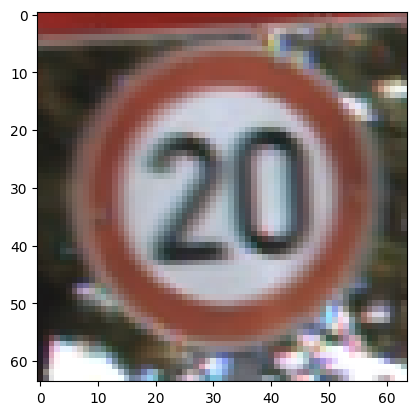

In [3]:
test_image_path:str = "dataset/GTSRB/Final_Training/Images/00000/00001_00029.ppm"
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

In [4]:
images_path = "dataset/GTSRB/Final_Training/Images/"
folder_list = os.listdir(images_path)
folder_list.sort()
print(os.listdir(images_path + folder_list[0]))

['00006_00000.ppm', '00004_00015.ppm', '00002_00000.ppm', '00002_00014.ppm', '00000_00011.ppm', '00001_00002.ppm', '00000_00010.ppm', '00003_00019.ppm', '00003_00024.ppm', '00006_00026.ppm', '00004_00013.ppm', '00004_00007.ppm', '00001_00010.ppm', '00000_00012.ppm', '00003_00017.ppm', '00003_00010.ppm', '00002_00008.ppm', '00001_00012.ppm', '00003_00014.ppm', '00002_00002.ppm', '00006_00014.ppm', '00005_00026.ppm', '00004_00016.ppm', '00000_00008.ppm', '00000_00023.ppm', '00000_00013.ppm', '00006_00015.ppm', '00005_00029.ppm', '00006_00018.ppm', '00000_00015.ppm', '00004_00008.ppm', '00004_00005.ppm', '00002_00024.ppm', '00000_00019.ppm', '00002_00021.ppm', '00001_00026.ppm', '00006_00012.ppm', '00001_00014.ppm', '00004_00021.ppm', '00005_00003.ppm', '00002_00023.ppm', '00002_00029.ppm', '00000_00005.ppm', '00006_00020.ppm', '00005_00019.ppm', '00006_00013.ppm', '00006_00003.ppm', '00001_00025.ppm', '00005_00009.ppm', '00005_00022.ppm', '00000_00006.ppm', '00000_00001.ppm', '00000_0001

In [5]:
for folder in folder_list:
    images = os.listdir(images_path + folder)
    print(images)

['00006_00000.ppm', '00004_00015.ppm', '00002_00000.ppm', '00002_00014.ppm', '00000_00011.ppm', '00001_00002.ppm', '00000_00010.ppm', '00003_00019.ppm', '00003_00024.ppm', '00006_00026.ppm', '00004_00013.ppm', '00004_00007.ppm', '00001_00010.ppm', '00000_00012.ppm', '00003_00017.ppm', '00003_00010.ppm', '00002_00008.ppm', '00001_00012.ppm', '00003_00014.ppm', '00002_00002.ppm', '00006_00014.ppm', '00005_00026.ppm', '00004_00016.ppm', '00000_00008.ppm', '00000_00023.ppm', '00000_00013.ppm', '00006_00015.ppm', '00005_00029.ppm', '00006_00018.ppm', '00000_00015.ppm', '00004_00008.ppm', '00004_00005.ppm', '00002_00024.ppm', '00000_00019.ppm', '00002_00021.ppm', '00001_00026.ppm', '00006_00012.ppm', '00001_00014.ppm', '00004_00021.ppm', '00005_00003.ppm', '00002_00023.ppm', '00002_00029.ppm', '00000_00005.ppm', '00006_00020.ppm', '00005_00019.ppm', '00006_00013.ppm', '00006_00003.ppm', '00001_00025.ppm', '00005_00009.ppm', '00005_00022.ppm', '00000_00006.ppm', '00000_00001.ppm', '00000_0001

### Transforming the data
Images represented in the dataset have highly inconsistant dimensions. In order to feed the data to a CNN model we need to have the data set of images that can be converted to array of consistant size, the size of 64x64 was chosed as it was somewhat average. Seeing how transformation by resizing affect the images in the dataset as a mojority of images in the dataset have non equal x and y dimensions.

(64, 64, 3)


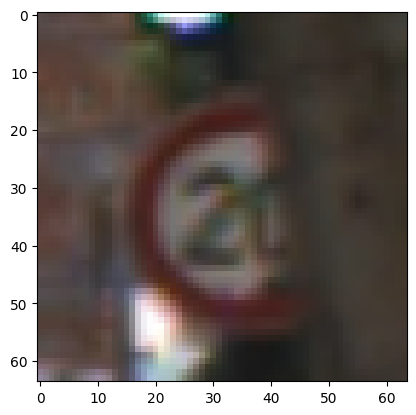

In [6]:
test_image_path:str = "dataset/GTSRB/Final_Training/Images/00000/00006_00000.ppm"
img = cv2.imread(test_image_path)
img = cv2.resize(img, (64,64))
cv2.imwrite("test.png", img)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

### Image Pre-Processing
In this part we are taking the supplied image data from the GTSRB dataset and scaling it up to uniform dimensions of 64x64 and saving the new images in png format into a separate folder. 

In [7]:
processed_data_path = "processed_data/"
for folder in folder_list:
    images = os.listdir(images_path + folder)
    images = list(filter(lambda item:not item.endswith(".csv"),images))
    if not os.path.exists(f"{processed_data_path}{folder}"):
        os.mkdir(f"{processed_data_path}{folder}")
    for image in images:
        img_path = f"{images_path}{folder}/{image}"
        save_path = f"{processed_data_path}{folder}/{image}"
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64,64))
        cv2.imwrite(save_path[0:-4]+".png", img)
        
    

### Creating labels file
Creating a csv file that lists all of the newly pre-processed images with their path and attaches the label to them, the data set has been sorted previously so the label depends only on the name of subfolder that an individual image is storred in. 

In [8]:
df = pd.DataFrame()
img_path_list = []
folder_list = os.listdir(f"{processed_data_path}")
for folder in folder_list:
    images = f"{processed_data_path}{folder}/" + np.array(os.listdir(f"{processed_data_path}{folder}"))
    img_path_list.append(images)
img_path_list = np.concatenate(img_path_list)
df["Path"] = img_path_list
df.to_csv("labels.csv")
labels = np.array([int(label.split('/')[1]) for label in img_path_list])
df["Labels"] = labels
df.to_csv("labels.csv")
        

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Preparing dataset for model training
Defining a Dataset class to load the tensor label pairs and dataloader to feed the training in batches

In [10]:
from torch.utils.data import Dataset
class GTSRBImageDataset(Dataset):
    def __init__(self, label_file, file_dir = "", transform = None):
        self.df = pd.read_csv(label_file)
        self.labels = df["Labels"]
        self.file_names = df["Path"]
        self.file_dir = file_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        file_path = os.path.join(self.file_dir, self.file_names[index])
        img = cv2.imread(file_path)
        label = self.labels[index]
        if self.transform:
            img = self.transform(img)
        return img, label

In [11]:
from torchvision.transforms import ToTensor
transform = ToTensor()
dataset = GTSRBImageDataset("labels.csv", transform=transform)

In [12]:
from torch.utils.data import random_split
train, test = random_split(dataset, [0.7,0.3])
training_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=True)

In [55]:
import torch.nn.functional as F


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

net = SimpleCNN(43)
print(net)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=43, bias=True)
)


In [56]:
net.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [57]:

from tqdm import tqdm
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
from torchmetrics import Accuracy
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None, num_classes=10):
    model.to(device)
    loss_fn.to(device)
    model.train()
    
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    acc_train.reset()

    with tqdm(train_loader, unit="batch") as tepoch:
        if epoch is not None:
            tepoch.set_description(f"Epoch {epoch}")

        for inputs, targets in tepoch:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad() 
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()

            loss_train.update(loss.item())
            acc_train.update(outputs, targets.int())

            tepoch.set_postfix(loss=loss_train.avg)

    final_accuracy = acc_train.compute().item()
    return model, loss_train.avg, final_accuracy

In [58]:
for epoch in range(20):
    net, loss, acc = train_one_epoch(net, training_loader, criterion, optimizer, num_classes=43, epoch=epoch)
print(f"Model accuracy {acc}, Loss {loss}")

Epoch 19: 100%|██████████| 858/858 [00:09<00:00, 89.85batch/s, loss=0.00233]

Model accuracy 0.9999635815620422, Loss 0.0023312290347130243


In [109]:
import sklearn.metrics as metrics
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=43).to(device)
    predictions, labels = [], []
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
      predictions.append(torch.max(outputs.data, 1)[1].cpu().numpy())
      labels.append(targets.cpu().numpy())
    predictions = np.concatenate(predictions)
    labels = np.concatenate(labels)
    confusion = metrics.confusion_matrix(labels,predictions)
  return loss_valid.avg, acc_valid.compute().item(), confusion

In [115]:
test_loss, test_acc, confusion = validation(net, test_loader, criterion)
print(f"Test accuracy {test_acc}, test loss {test_loss}")
def print_array(array):
  np.set_printoptions(threshold=np.inf)
  print(array)
  np.set_printoptions(threshold=1000)
print_array(confusion)


Test accuracy 0.9958340525627136, test loss 0.020867088999417003
[[ 71   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  1 624   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   1 676   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0 413   0   0   0   0   0   0   0   0   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   2   0 605   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   1   0 553   0   2   2   